# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid.inset_locator import inset_axes
%matplotlib notebook

import re
from scipy.integrate import odeint, solve_ivp

# Decalaring Paths

In [3]:
results_path = '../Notebook Results/Chapter 1/'

# Initializations

In [4]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [5]:
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.figsize'] = (10,5)
cos = np.cos
sin = np.sin
exp = np.exp
pi = np.pi
arctan = np.arctan

# Body Mass Simulation

In [8]:
class SinePlaneSimulator:
    
    def __init__(self, d_0 = (0, 0.2), v_0 = 2, a_0 = 0, vel_0 = 10,
                 static_fric_coef = 0.0, gravitational_force = 9.8, mass = 2,
                 timesteps = 2*pi, vector_skips=5, interval=100):
        
        ## Initial States
          # Constants
        self.g = gravitational_force
        self.mu_s = static_fric_coef
        self.mass = mass
        self.mass_height  = 0.03
        self.mass_width   = 2.0
        self.path_base = 3
        
        # Displacement
        self.D_x_0 = d_0[0]
        self.D_y_0 = d_0[1]
        
        # Velocity
        self.V_x_0 = v_0
        self.V_y_0 = 0
        
        # Acceleration
        self.A_x_0 = 0
        self.A_y_0 = self.g
        
        # Contact Angle
        self.theta_c_0 = 0
        
        # Time Related
        self.timesteps = timesteps
        self.simulation_time = np.linspace(0, self.timesteps, 20*(self.timesteps)+1)
        self.labels_changed = False
        self.vector_skips = vector_skips
        self.interval = interval
        
    @staticmethod
    def get_deriv(t, state, g, mus):
        
        _theta_c = state[0]
        _D_x     = state[1]
        _D_y     = state[2]
        _V_x     = state[3]
        _V_y     = state[4]
        
        
        # Derivative of Contact Angle
        d_theta_c = -cos(t)/(1+(sin(t)**2))
        
        # Derivative of Distance
        d_D_x    = _V_x
        d_D_y    = _V_y
        
        # Derivative of Velocity
        d_V_x = g*cos(_theta_c)*(sin(_theta_c) - mus*cos(_theta_c))*d_theta_c
        d_V_y = g*sin(_theta_c)*(sin(_theta_c) - mus*cos(_theta_c))*d_theta_c

        next_state = [d_theta_c, d_D_x, d_D_y, d_V_x, d_V_y]
        
        return next_state

    def calculate_deriv(self):
        
        maxy = max(self.path_base*0.5*(cos(self.simulation_time)+3))
        state0 = [self.theta_c_0, self.D_x_0, maxy, self.V_x_0, self.V_y_0]
        g = self.g
        mus = self.mu_s
        oderes = odeint(self.get_deriv,
                        state0,
                        self.simulation_time,
                        args=(g, mus),
                        tfirst=True)
        self.oderes = oderes
        
        _thetac = oderes[:,0]

        self.accel_x = g*cos(_thetac)*(sin(_thetac) - mus*cos(_thetac))
        self.accel_y = g*sin(_thetac)*(sin(_thetac) - mus*cos(_thetac))
        self.accel = np.sqrt(self.accel_x**2, self.accel_y**2)
        
        self.vel_x = oderes[:,3]
        self.vel_y = oderes[:,4]
        self.vel = np.sqrt(self.vel_x**2, self.vel_y**2)
        
        self.va_coord = np.c_[self.simulation_time, self.vel, self.accel]

    def init_plot(self):
        
        self.axes.set_title(r'$Dynamics\ Of\ Motion\ in\ Siusoidal\ Plane$')
        self.axes.set_facecolor('k')
        self.axes.grid()
#         self.axes.get_xaxis().set_ticks([])
#         self.axes.get_yaxis().set_ticks([])
        self.axes.set_ylim(0, self.path_base*2.5)
        self.axes.fill_between(self.simulation_time, 
                               self.path_base*0.5*(cos(self.simulation_time)+3),
                               0, color='#e8a864')
        self.va_axes = inset_axes(self.axes, width="35%", height="25%", loc=4,
                                  bbox_to_anchor=(-0.12,0.07,1,1), bbox_transform=self.axes.transAxes)
        self.va_axes.patch.set_alpha(0.5)
        self.va_axes.set_facecolor('#ffefd6')
        for spine in self.va_axes.spines.values(): spine.set_edgecolor('white')
        self.va_axes.grid(color='w', linestyle='-.', linewidth=0.3)
        self.va_axes.tick_params(axis='both', colors='w')
        self.va_axes.set_xlabel(r'$Time \longrightarrow$', color='w')
        self.va_axes.set_ylabel(r'$Velocity(ms^{-1}) \longrightarrow$', color='#2278b3')
        self.va_axes_ty = self.va_axes.twinx()
        for spine in self.va_axes_ty.spines.values(): spine.set_edgecolor('white')
        self.va_axes_ty.tick_params(axis='both', colors='w')
        self.va_axes_ty.set_ylabel(r'$Acceleration(ms^{-2}) \longrightarrow$', color='#944601')
        
        # Set up the mass
        bboxprop = dict(facecolor='wheat',boxstyle='round',color='lightgray', edgecolor='w', lw=2)
        self.masstext = self.axes.text(self.oderes[:,1][0],
                                       self.oderes[:,2][0]+0.2, r'$m$',
                                       color='#63492a', fontsize = 20, bbox = bboxprop)
        
        # Set up the Time Patch
        bbox_prop = dict(facecolor='wheat',boxstyle='round', edgecolor='w', lw=3)
        self.time_text = r'$Time : {0}$'.format(self.simulation_time[0])
        self.timetext = self.fig.text(0.8, 0.88, self.time_text,
                                       color='#63492a', fontsize = 20,
                                       bbox = bbox_prop)
        
        # Velocity and Accel plot
        self.velocityplt, = self.va_axes.plot((self.va_coord[:,0][0], self.va_coord[:,1][0]))
        self.accelplt, = self.va_axes_ty.plot((self.va_coord[:,0][0], self.va_coord[:,2][0]))
        
        self.velocitysct = self.va_axes.scatter(self.va_coord[:,0][0], self.va_coord[:,1][0],
                                                edgecolor = 'w')
        self.accelsct = self.va_axes_ty.scatter(self.va_coord[:,0][0], self.va_coord[:,2][0], 
                                                color='#944601', edgecolor = 'w')
        
        self.va_axes.set_ylim(0, max(self.va_coord[:,1])*1.2)
        self.va_axes_ty.set_ylim(0, max(self.va_coord[:,2])*1.2)
        
        return self.fig,
    
    def update_plot(self, i):
        
        next_pos = self.oderes[:,:3][i]
        next_angle = self.oderes[:,0][i]
        self.masstext.set_position((self.simulation_time[i], next_pos[2]+0.2))
        self.masstext.set_rotation(np.rad2deg(next_angle))
        self.timetext.set_text(r'$Time : {0}s$'.format(np.round(self.simulation_time[i], 1)))
        
        self.va_axes.set_xlim(0, self.simulation_time[i]*1.2)
        time, vel, accel = self.va_coord[:i,0], self.va_coord[:i,1], self.va_coord[:i,2]
        self.velocityplt.set_data(time, vel)
        self.accelplt.set_data(time, accel)
        
        self.velocitysct.set_offsets((time[-1], vel[-1]))
        self.accelsct.set_offsets((time[-1], accel[-1]))
        
        return self.fig,
    
    def start_simulation(self):
        self.fig, self.axes = plt.subplots()
        self.fig.tight_layout()
        self.calculate_deriv()
        self.ani=FuncAnimation(fig=self.fig, func=self.update_plot, init_func=self.init_plot,
                               interval=self.interval, blit=True, save_count = 1000)
        plt.show()


<IPython.core.display.Javascript object>


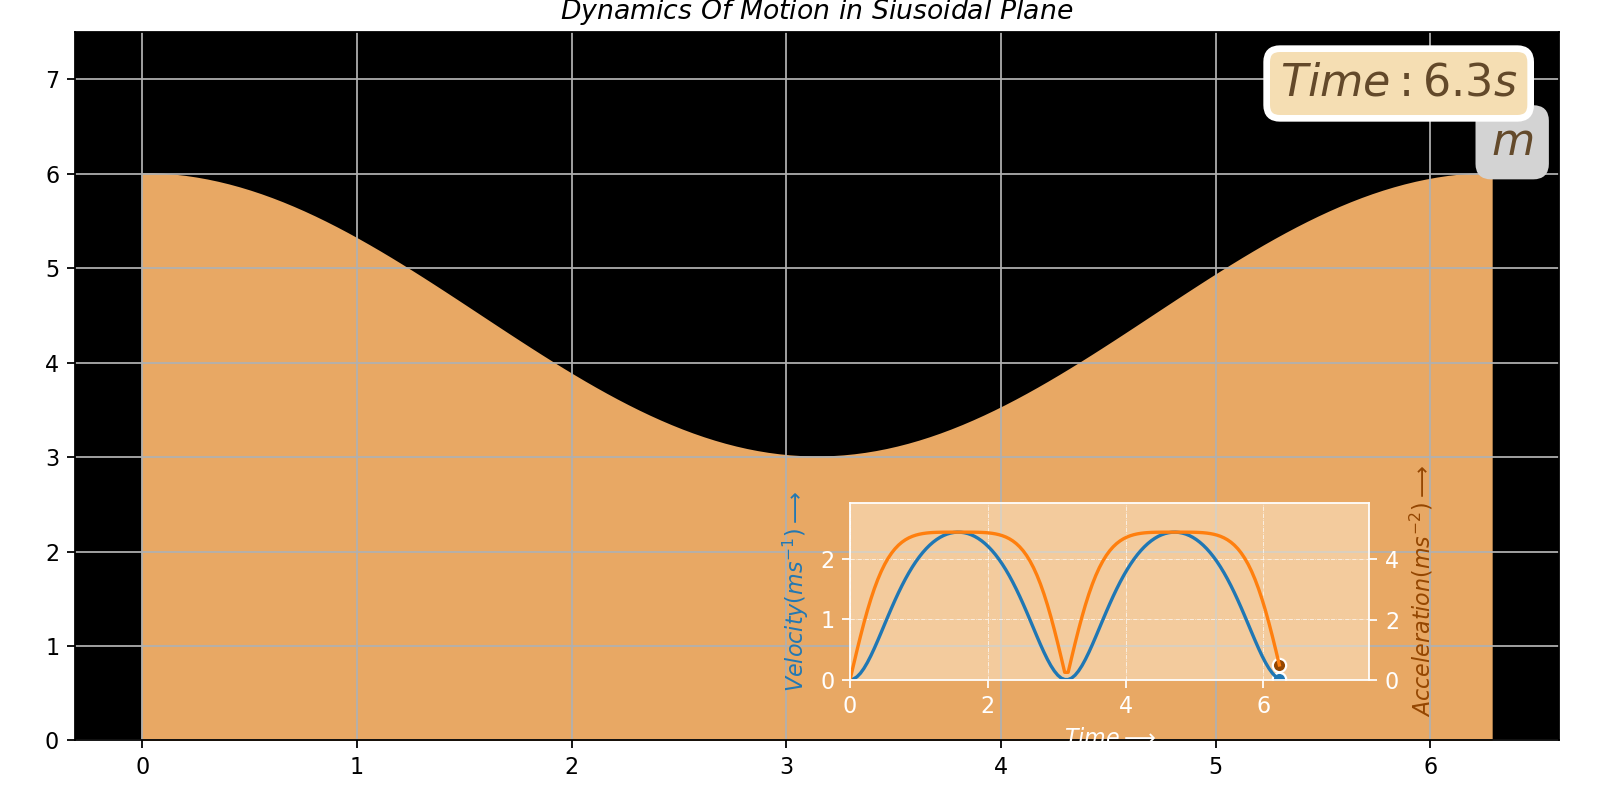

In [9]:
np.set_printoptions(suppress=True)
sinplaneSim = SinePlaneSimulator(v_0 = 0, timesteps = 2*np.pi,
                                 static_fric_coef=0., interval=1)
sinplaneSim.start_simulation()

# Random Testing Space

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
%matplotlib inline

In [3]:
# Initialisations
sin = np.sin
cos = np.cos
arctan = np.arctan
pi = np.pi
g = -9.8
mus = 0.0

In [4]:
# Initial Conditions
theta_0 = 0
x_0, y_0 = 0, 10
vx_0, vy_0 = 20, 0
ax_0, ay_0 = 0, -g
mass_width , mass_height = 0.5, 0.5

In [7]:
def get_deriv(t, state, g, mu, y_0):
    
    _Theta = state[0]
    _D_x   = state[1]
    _D_y   = state[2]
    _V_x   = state[3]
    _V_y   = state[4]

    # Derivative of Contact Angle
    d_Theta = cos(t)/(1+(sin(t)**2))

    # Velocity
    _V = np.sqrt(_V_x**2 + _V_y**2)
    
    # Radius Of Curvature
    _roc = (1 + (y_0*sin(t))**2)**1.5 / (-y_0*cos(t))
    _roc_sign = (_roc / abs(_roc))
    _roc = abs(_roc)
    
    # Derivative of distance
    d_D_x   = _V_x
    d_D_Y   = _V_y
    
    # Derivative Velocity
    d_V_x = (g*cos(_Theta) - (_V**2/(_roc))) * (sin(_Theta) - mu*cos(_Theta))
    d_V_y = g - (g*cos(_Theta) - (_V**2/(_roc))) * (cos(_Theta) + mu*sin(_Theta)) 

    # Next State Derivative Vector
    next_state = [d_Theta, d_D_x, d_D_Y, d_V_x*d_Theta, d_V_y*d_Theta]

    return next_state


[0, 0, 10, 20, 0]
0.1
0.10000000000001401
0.10000000000001401
0.10000000000005599
0.10000000000005599
0.1000000008699527
0.1000000008699527
0.10000000026526844
0.10000000026526844
0.10000000104571603
0.10000000104571603
0.10000000083637824
0.10000000083637824
0.10000000172668051
0.10000000172668051
0.10000000418220914
0.10000000418220914
0.1000000077064974
0.1000000077064974
0.10000001229954537
0.10000001229954537
0.1000001170118242
0.1000001170118242
0.10000005013128446
0.10000005013128446
0.10000001782296686
0.10000001782296686
0.1000000243678514
0.1000000243678514
0.10000003193419915
0.10000003193419915
0.10000004052201014
0.10000004052201014
0.1000000607620222
0.1000000607620222
0.10000008508788841
0.10000008508788841
0.10000011349960977
0.10000011349960977
0.1000001459971874
0.1000001459971874
0.10000044298179732
0.10000044298179732
0.10000090068079184
0.10000090068079184
0.10000151909490647
0.10000151909490647
0.10000229822513522
0.10000229822513522
0.10000215705689935
0.10000215

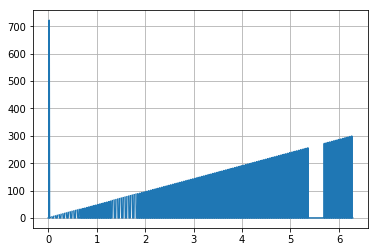

In [10]:
time_max = 2*pi
time = np.linspace(0, time_max, 1000)
path_coord = np.c_[time, y_0*0.5*(cos(time) + 1)]

initial_state = [theta_0, x_0, y_0, vx_0, vy_0]

print(initial_state)
oderes = odeint(get_deriv, initial_state, time,
                args=(g, mus, y_0), tfirst=True)

theta, x, y, vx, vy = oderes[:,0], oderes[:,1], oderes[:,2], oderes[:,3], oderes[:,4]
oderes = np.c_[time, theta, x, y, vx, vy]

plt.plot(oderes[:, 0], np.rad2deg(oderes[:, 1]))
plt.grid()